# Assignment 6 : Pretrain and Transfer Learning (20 pts)

### Before working on the assignment please read papers as following 
- SUPERVISED CONTRASTIVE LEARNING FOR PRE-TRAINED LANGUAGE MODEL FINE-TUNING
  - link: https://openreview.net/pdf?id=cu7IUiO
- Few-Shot Intent Detection via Contrastive Pre-Training and Fine-Tuning
  - link: https://arxiv.org/abs/2109.06349

## Question 1: Why do we need transfer learning ? (1.5pts)

In [1]:
#answer1

## Question 2: When transfer learning makes sense ? (1.5pts)

In [2]:
#answer2

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AdamW
import random
from IPython.display import clear_output
from utils import create_supervised_pair, supervised_contrasive_loss, Similarity

#comment this if you are not using puffer
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

## To download data from file directory both text samples and labels

In [1]:
def load_examples(file_path, do_lower_case=True):
    examples = []
    
    with open('{}/seq.in'.format(file_path),'r',encoding="utf-8") as f_text, open('{}/label'.format(file_path),'r',encoding="utf-8") as f_label:
        for text, label in zip(f_text, f_label):
            
            e = Inputexample(text.strip(),label=label.strip())
            examples.append(e)
            
    return examples

## Each sample has a sentence and label format

In [2]:
class Inputexample(object):
    def __init__(self,text_a,label = None):
        self.text = text_a
        self.label = label

### Question3 : Write the code to be able  to control batching data process for the sake of fine-tuning models with combining  cross entropy and supervised contrastive loss in question 5, and only cross entropy in question 4. (7pts)
    
 * assume : we have batch size = 4 but we have 64 classes, so sometime batching process will random sample in a batch, and then it has no any samples come from the same classes like below  
    
    * samples_sentence = ['a','b','c','d'] : assume that one alphabet represent one sentence or one sample
    * labels = [0,1,2,3] ; Therefore, if a batch has unqiue classes equal to batch size, this batch will be skipped due to equation "1yi=yj" of supervised contrastive loss(equation in question 5) that's reason why we need to force like below buttlet. 
    
  * you can see at least one pair that come from the same class.
    
    Therefore, we want dataloader to output like below 
   
    * samples_sentence = ['a','b','c','f'] 
    * labels = [0,1,2,0] ; this batch will pass condition as "1yi=yj" because the label of y[0] = 0, y[3] = 0 in list of labels.

In [5]:
# create custom dataset class
# ===  =  Hint =  ===
# can train on two condition 
# 1.) trainig training with supervise contrastive loss and cross entropy loss using in question 5.) 
#    when self.repeated_label == True:
# 2.) train only cross entropy loss use in question 4.)
#    when self.repeated_label == False:
class CustomTextDataset(Dataset):
    def __init__(self,labels,text,batch_size,repeated_label:bool=False):
        self.labels = labels
        self.text = text
        self.batch_size = batch_size 
        self.count = 0 
        self.repeated_label = repeated_label
        
        # to use when training with supervise contrastive loss
        if self.repeated_label == True:
           # write the code here
           pass
          

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        # write code here for 1)

         
        label = self.labels[idx]
        
        data = self.text[idx]
        
        sample = {"Class": label,"Text": data}


    
        return sample

### What is Few-shot Learning ?
   - few-shot learning is the process of train model on small amount of data in each class to guide model on specific taks, opposed to standard fine-tuning method which requires a large amount of training data for the pretrained model to adapt to the desired task with accuracy.
   
source : https://huggingface.co/blog/few-shot-learning-gpt-neo-and-inference-api

## Define Parameters

In [6]:
N = 5
data = []
labels = []
train_samples = []
train_labels = []
embed_dim = 768
batch_size = 4
lr= 1e-5  # you can adjust 
temp = 0.3  # you can adjust 
lamda = 0.01  # you can adjust  
skip_time = 0 # the number of time that yi not equal to yj in supervised contrastive loss equation 
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

### The Aim of these training is to fine tuning on few shot setting on text classification task

Path example of train, validation and test 

In [13]:
path_5shot = f'./HWU64/train_5/'
path_test = f'./HWU64/test/'
path_valid = f'./HWU64/valid/'

### Dataset Structure
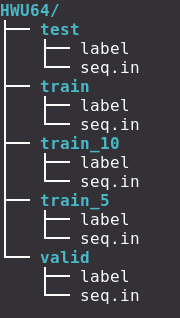

In [12]:
!unzip HWU64.zip

Archive:  HWU64.zip
   creating: HWU64/
   creating: HWU64/valid/
 extracting: HWU64/valid/label       
 extracting: HWU64/valid/seq.in      
   creating: HWU64/train_5/
 extracting: HWU64/train_5/label     
 extracting: HWU64/train_5/seq.in    
   creating: HWU64/train_10/
 extracting: HWU64/train_10/label    
 extracting: HWU64/train_10/seq.in   
   creating: HWU64/train/
 extracting: HWU64/train/seq.in      
 extracting: HWU64/train/label       
   creating: HWU64/test/
 extracting: HWU64/test/label        
 extracting: HWU64/test/seq.in       


In [14]:

# https://downgit.github.io/#/home?url=https:%2F%2Fgithub.com%2Fjianguoz%2FFew-Shot-Intent-Detection%2Ftree%2Fmain%2FDatasets%2FHWU64

# downloading training samples 
train_samples = load_examples(path_5shot)

# write code here : for downloading validation samples

#write code here : for downloading test samples

# preprocess for training 
for i in range(len(train_samples)):
    data.append(train_samples[i].text)
    labels.append(train_samples[i].label)
    
# write code here :preprocess validation samples

# write code here : preprocess test samples

# dataloader for training 
train_data = CustomTextDataset(labels,data,batch_size=batch_size,repeated_label=True)
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)


# write code here : dataloader for validation


# write code here : dataloader for test


# got the number of unique classes from dataset
num_class = len(np.unique(np.array(labels)))

# get text label of uniqure classes
unique_label = np.unique(np.array(labels))

# map text label to index classes
label_maps = {unique_label[i]: i for i in range(len(unique_label))}

# Download tokenizer that use to tokenize sentence into words by using Pretrain from roberta-base
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

## Download Pretrain Model

In [15]:
# download config of Roberta config 
config = RobertaConfig.from_pretrained("roberta-base",output_hidden_states=True)

#chnage modifying the number of classes
config.num_labels = num_class
# Download pretrain models weight 
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
# change from binary classification to muli-classification and loss automatically change to cross entropy loss
model.num_labels = config.num_labels
# change the output of last layer to num_class that we want to predict
model.classifier.out_proj = nn.Linear(in_features=embed_dim,out_features=num_class)
# move to model to device that we set
model = model.to(device)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [16]:
# Using adam optimizer 
optimizer= AdamW(model.parameters(), lr=lr)

## Question3: write function to freeze model (3pts)


In [39]:
def freeze_layers(model,freeze_layers_count:int):

        """
        model : model object that we create 
        freeze_layers_count : the number of layers to freeze 
        """
        # write the code here
    
        
        return model

## Question4: Training on text classification task on CrossEntropy loss (3.5 pts)
- Using API of hugging face of RobertaForSequenceClassification
  - source : https://huggingface.co/transformers/v3.0.2/model_doc/roberta.html#robertaforsequenceclassification
- report performance of models (test acc) with differrent experiement of unfreezing of bottom layers and compare the result of each
    - 4.1. freeze weight from pretrain model all layer except classifier 
    - 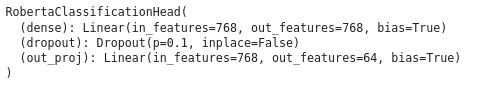
    
   
    - 4.2. freeze all from top embeddings to encoder layers (9)
      - embeddings
        - 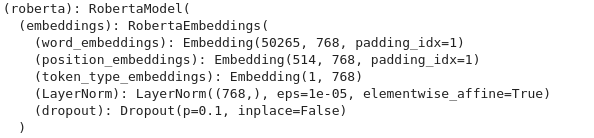
      - layer 9
        - 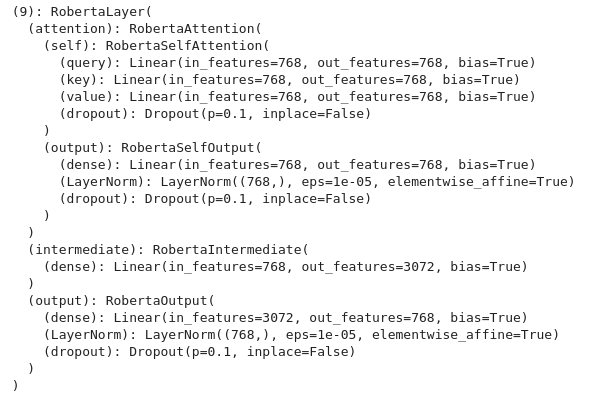
    - 4.3 add code to collect loss and accuracy of training history  of (4.1 and 4.2)
    - 4.4 add the code in below in training loop collect validation loss and accuracy history of (4.1 and 4.2)
    
- hint: for this training on Cross entropy loss no need to control the outcome of class in each batch using code below to train model base on how many layers that you freeze  
  - to see whole architecture look like you can use mode.eval() 

In [ ]:
# this code training models on Cross entropy loss
for epoch in range(30):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
        
        # move parameter to device
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

        #print("show out: ",np.unique(labels, return_counts=True))
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)


        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

         # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels)
        # you can check 
        loss, logits = outputs[:2]
        
        loss.backward()
        optimizer.step()
       
        # write code here 
        # to save model eg. model.pth look at pytorch document how to save model
        
        print(f'[{epoch + 1}, {idx}] loss: {loss.item()}')
        print(running_loss)  
        clear_output(wait=True)

   - 4.5 write code to plot both loss and accuracy for training and validation repectively.
   - 4.6 write test function to get test accuracy for (4.1,4.2) 

In [ ]:
# write code here for 4.5 and 4.6

# Question 5: Training on text classification task  on combine two losses Cross Entropy and Supervised Contrastive. (3.5 pts)

- Cross Entropy loss
$$
\mathcal{L}_\text{CE} =-\frac{1}{m} \sum_{i=1}^{m} yi \cdot log(\hat{yi})
$$

- Supervised Contrastive learning loss
$$
\mathcal{L}_\text{S_cl} = -\frac{1}{T}\sum_{i=1}^{N}\sum_{j=1}^{N} \boldsymbol{1_{yi=yj}}\enspace log \frac{e^{sim(hi,hj) / \tau}}{\sum_{n=1}^{N} e^{sim(hi,hn) / \tau}}
$$
     * detail 
       * ui ~ sentence i 
       * hi ~ BERT(ui) in our case using Roberta as a encoder
       * hi : (batch_size,sequence_len,embed_size)
       * hi is the output of model which is last hidden layers before classifier head in the model architecture
       * 1yi=yj ~ we select only the sample that come from the same class to compute in each i and j
       * T ~ the number of pairs that come from the same classes
       * $\tau$ ~ temperature parameter
       * Sim(x1,x2) : cosine similarity [-1, 1]
       - $\lambda'$ is just weighted of cross entropy loss 
       * Sim function is the cosine similarity 
       * N ~ the number of samples in a batch
$$
sim(A,B) = \cos{(\theta)} = \frac{A\cdot B}{|\!|A|\!||\!|B|\!|}
$$


- Loss total
$$
  \mathcal{L}_\text{total} = \mathcal{L}_\text{s_cl} + \lambda ' \mathcal{L}_{CE}
$$

* you can get cross entropy loss like below 
    * outputs = model(input_ids, labels=labels)
    * loss, logits = outputs[:2]
    * loss : this is cross entropy loss
      
- hint : for this question you will utilize the function CustomTextDataset to force dataloader to have at least one pair that come from the same class
     * eg. batch_size = 4 
     * the labels in a batch should be like [ 0, 21, 43, 0]  
     
5. training this model in the code below on loss_total by do experiment the same as question 4.1, 4.2, 4.3, 4.4, 4.5, 4.6

In [40]:
for epoch in range(30):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for (idx, batch) in enumerate(train_loader):
        sentence = batch["Text"]
        inputs = tokenizer(sentence,padding=True,truncation=True,return_tensors="pt")
        inputs = {k:v.to(device) for k,v in inputs.items()}

        # map string labels to class idex
        labels = [label_maps[stringtoId] for stringtoId in (batch['Class'])]

        
        # convert list to tensor
        labels = torch.tensor(labels).unsqueeze(0)
        labels = labels.to(device)


        #(batch_size, seq_len)
        #print(inputs["input_ids"].shape)

         # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(**inputs,labels=labels,output_hidden_states=True)     
        
        hidden_states = outputs.hidden_states
        
        last_hidden_states = hidden_states[12]
        
        # https://stackoverflow.com/questions/63040954/how-to-extract-and-use-bert-encodings-of-sentences-for-text-similarity-among-sen 
        # (batch_size,seq_len,embed_dim)
        h = last_hidden_states[:,0,:]
        
        # create pair samples
        T, h_i, h_j, idx_yij = create_supervised_pair(h,batch['Class'],debug=False)
        
        if h_i is None:
            print("skip this batch")
            skip_time +=1
            continue
               
        # supervised contrastive loss 
        loss_s_cl = supervised_contrasive_loss(h_i, h_j, h, T,temp=temp,idx_yij=idx_yij,debug=False)
        
        # cross entropy loss
        loss_classify, logits = outputs[:2]
        
        # loss total
        loss = loss_s_cl + (lamda * loss_classify)
        
        loss.backward()
        optimizer.step()
       
        
        print(f'[{epoch + 1}, {idx}] loss_total: {loss.item()}, loss_s_cl:{loss_s_cl.item()}, loss_classify:{lamda * loss_classify.item()}')
       
        clear_output(wait=True)        

[2, 62] loss_total: 1.4274049997329712, loss_s_cl:1.3862911462783813, loss_classify:0.04111388683319092


KeyboardInterrupt: 